In [17]:
#Task 1 sentiment labeling
!pip install vaderSentiment


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [4]:
df = pd.read_csv("test(in).csv")
df.head()


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [5]:
df.info()
df.describe()
df.dropna(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2191 non-null   object
 1   body     2191 non-null   object
 2   date     2191 non-null   object
 3   from     2191 non-null   object
dtypes: object(4)
memory usage: 68.6+ KB


In [7]:
df.columns


Index(['Subject', 'body', 'date', 'from'], dtype='object')

In [8]:
# Initialize VADER analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis on 'body' column
df["sentiment_score"] = df["body"].apply(lambda x: analyzer.polarity_scores(str(x))["compound"])

# Assign sentiment labels
df["sentiment_label"] = df["sentiment_score"].apply(
    lambda s: "positive" if s > 0 else ("negative" if s < 0 else "neutral")
)

df[["Subject", "body", "sentiment_score", "sentiment_label"]].head()


,Subject,body,sentiment_score,sentiment_label
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,0.8172,positive
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",0.4215,positive
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",0.0000,neutral
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,0.0000,neutral
4,Bet,Since you never gave me the $20 for the last t...,0.2500,positive


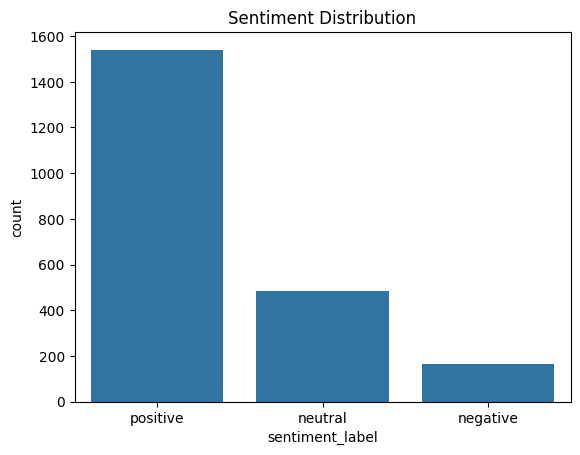

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="sentiment_label", data=df)
plt.title("Sentiment Distribution")
plt.show()


In [10]:
#Task 2 EDA
# Basic dataset summary
print("Dataset shape:", df.shape)
print("\nMissing values per column:\n", df.isnull().sum())

# Sentiment distribution
print("\nSentiment counts:\n", df["sentiment_label"].value_counts())

# Average sentiment per sender
avg_sent = df.groupby("from")["sentiment_score"].mean().sort_values(ascending=False)
print("\nTop 5 positive employees:\n", avg_sent.head())


Dataset shape: (2191, 6)

Missing values per column:
 Subject            0
body               0
date               0
from               0
sentiment_score    0
sentiment_label    0
dtype: int64

Sentiment counts:
 sentiment_label
positive    1541
neutral      486
negative     164
Name: count, dtype: int64

Top 5 positive employees:
 from
eric.bass@enron.com         0.472260
john.arnold@enron.com       0.462502
patti.thompson@enron.com    0.448559
johnny.palmer@enron.com     0.410969
lydia.delgado@enron.com     0.404190
Name: sentiment_score, dtype: float64


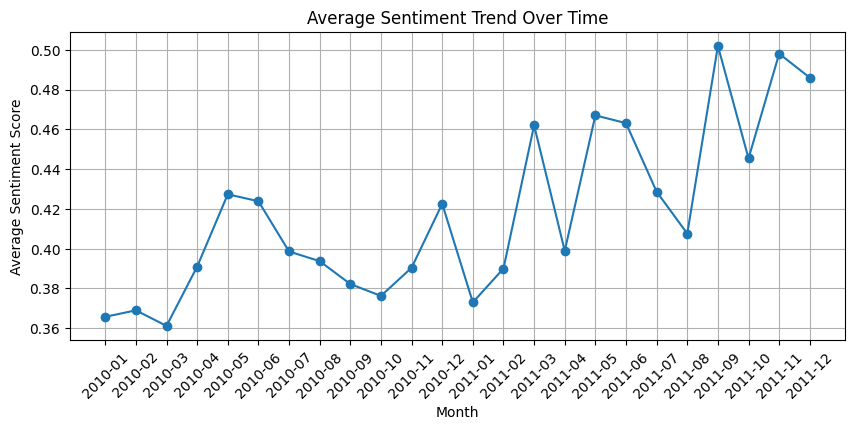

In [11]:
# Convert date column to datetime
df["date"] = pd.to_datetime(df["date"], errors='coerce')

# Extract month and year
df["month"] = df["date"].dt.to_period("M")

# Average sentiment per month
monthly_sentiment = df.groupby("month")["sentiment_score"].mean().reset_index()

plt.figure(figsize=(10,4))
plt.plot(monthly_sentiment["month"].astype(str), monthly_sentiment["sentiment_score"], marker="o")
plt.title("Average Sentiment Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Average Sentiment Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [18]:
#Task 3: Employee Monthly Sentiment Score
# Assign sentiment points
def score_label(label):
    if label == "positive":
        return 1
    elif label == "negative":
        return -1
    else:
        return 0

df["sentiment_point"] = df["sentiment_label"].apply(score_label)

# Monthly sentiment score per employee
monthly_scores = df.groupby(["from", "month"])["sentiment_point"].sum().reset_index()
monthly_scores.rename(columns={"sentiment_point": "monthly_score"}, inplace=True)

monthly_scores.head()


,from,month,monthly_score
0,bobette.riner@ipgdirect.com,2010-01,1
1,bobette.riner@ipgdirect.com,2010-02,7
2,bobette.riner@ipgdirect.com,2010-03,6
3,bobette.riner@ipgdirect.com,2010-04,4
4,bobette.riner@ipgdirect.com,2010-05,2


In [19]:
#Task 4: Employee Ranking
# Top 3 positive and negative employees per month
top_positive = monthly_scores.sort_values(["month", "monthly_score", "from"], ascending=[True, False, True]).groupby("month").head(3)
top_negative = monthly_scores.sort_values(["month", "monthly_score", "from"], ascending=[True, True, True]).groupby("month").head(3)

print("Top 3 Positive Employees by Month:")
display(top_positive)

print("\nTop 3 Negative Employees by Month:")
display(top_negative)


Top 3 Positive Employees by Month:


,from,month,monthly_score
120,kayne.coulter@enron.com,2010-01,13
48,eric.bass@enron.com,2010-01,9
144,lydia.delgado@enron.com,2010-01,9
73,john.arnold@enron.com,2010-02,11
97,johnny.palmer@enron.com,2010-02,10
...,...,...,...
22,bobette.riner@ipgdirect.com,2011-11,9
94,john.arnold@enron.com,2011-11,9
71,eric.bass@enron.com,2011-12,12
191,patti.thompson@enron.com,2011-12,12



Top 3 Negative Employees by Month:


,from,month,monthly_score
0,bobette.riner@ipgdirect.com,2010-01,1
96,johnny.palmer@enron.com,2010-01,1
192,rhonda.denton@enron.com,2010-01,1
121,kayne.coulter@enron.com,2010-02,-1
145,lydia.delgado@enron.com,2010-02,1
...,...,...,...
214,rhonda.denton@enron.com,2011-11,2
166,lydia.delgado@enron.com,2011-11,3
119,johnny.palmer@enron.com,2011-12,2
23,bobette.riner@ipgdirect.com,2011-12,3


In [20]:
#Task 5: Flight Risk Identification
# Filter negative messages
negatives = df[df["sentiment_label"] == "negative"].copy()
negatives["date"] = pd.to_datetime(negatives["date"])

flight_risk = []

for emp in negatives["from"].unique():
    emp_msgs = negatives[negatives["from"] == emp].sort_values("date")
    for i in range(len(emp_msgs)):
        start = emp_msgs.iloc[i]["date"]
        end = start + pd.Timedelta(days=30)
        count_30d = emp_msgs[(emp_msgs["date"] >= start) & (emp_msgs["date"] <= end)].shape[0]
        if count_30d >= 4:
            flight_risk.append(emp)
            break

flight_risk = list(set(flight_risk))
print("🚨 Employees flagged as Flight Risk:")
print(flight_risk)


🚨 Employees flagged as Flight Risk:
['john.arnold@enron.com', 'sally.beck@enron.com', 'don.baughman@enron.com', 'kayne.coulter@enron.com', 'johnny.palmer@enron.com', 'bobette.riner@ipgdirect.com']


In [21]:
#Task 6: Predictive Modeling (Linear Regression)
# Add message length feature
df["message_length"] = df["body"].apply(lambda x: len(str(x).split()))

# Average message length per employee per month
feature_data = df.groupby(["from", "month"]).agg({
    "sentiment_score": "mean",
    "message_length": "mean",
    "body": "count"
}).reset_index()

feature_data.rename(columns={"body": "message_count", "sentiment_score": "avg_sentiment"}, inplace=True)

# Prepare data for regression
X = feature_data[["message_length", "message_count"]]
y = feature_data["avg_sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MAE: 0.11442683190843084
R²: 0.12609692964194497
